Ultralytics Solutions: ✅ {'region': [(0, 0), (512, 0), (512, 512), (0, 512)], 'show_in': True, 'show_out': True, 'colormap': None, 'up_angle': 145.0, 'down_angle': 90, 'kpts': [6, 8, 10], 'analytics_type': 'line', 'json_file': None, 'records': 5, 'model': '/media/williancaddd/CODES/WORKSPACE-FIOTEC/eggs-count-algorithms/slice-ideia/best-v1.pt', 'show': False, 'boxes': False}
WARNING ⚠️ Environment does not support cv2.imshow() or PIL Image.show()
OpenCV(4.10.0) /io/opencv/modules/highgui/src/window.cpp:1301: error: (-2:Unspecified error) The function is not implemented. Rebuild the library with Windows, GTK+ 2.x or Cocoa support. If you are on Ubuntu or Debian, install libgtk2.0-dev and pkg-config, then re-run cmake or configure script in function 'cvShowImage'


0: 512x512 (no detections), 7.5ms
Speed: 1.1ms preprocess, 7.5ms inference, 1.5ms postprocess per image at shape (1, 3, 512, 512)
WARNING ⚠️ no tracks found!
[]
Ultralytics Solutions: ✅ {'region': [(0, 0), (512, 0), (512, 512)

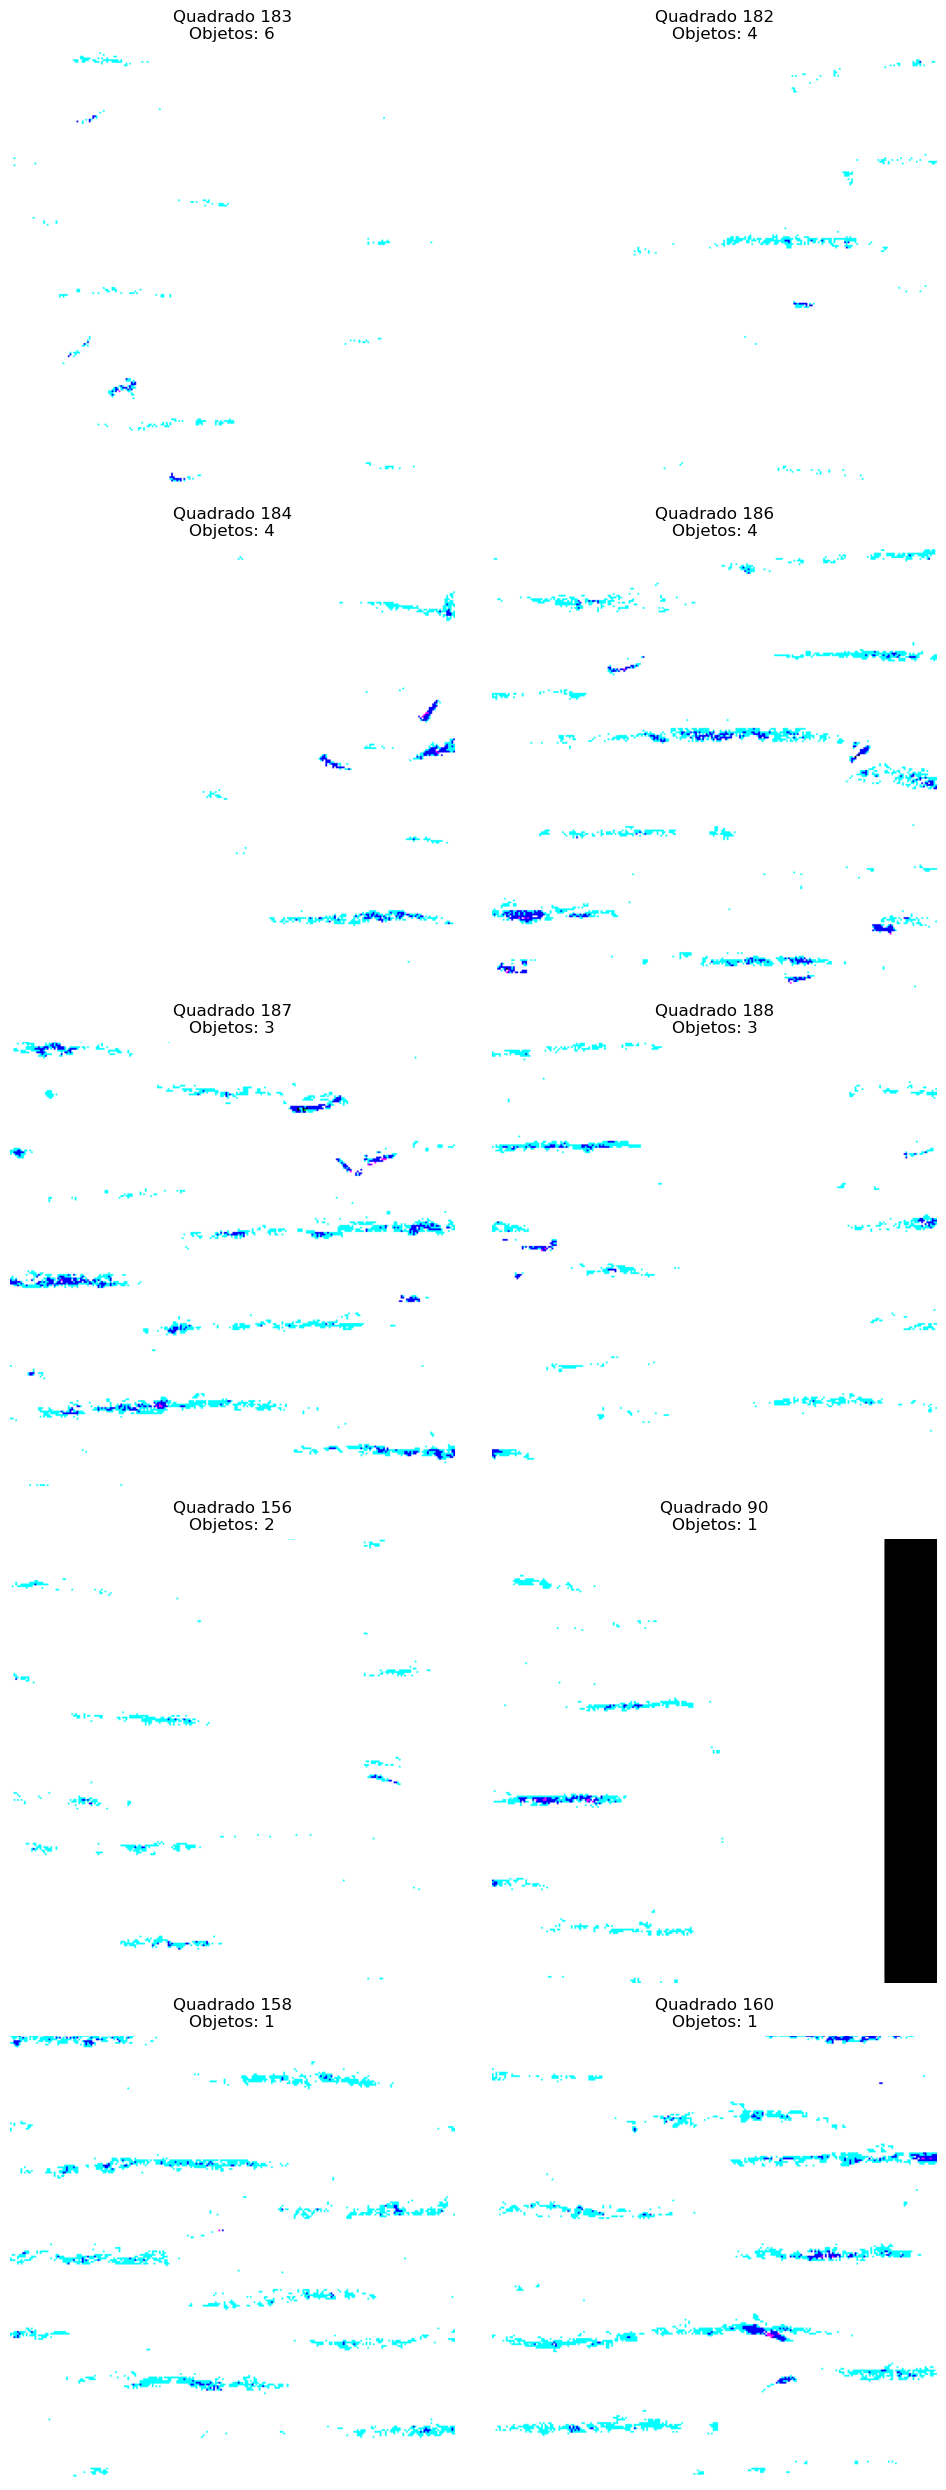

In [5]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
import os
import hashlib
from ultralytics import solutions
from skimage import io, exposure

# Constante para tamanho da janela deslizante
WINDOW_SIZE = 254
model_path = '/media/williancaddd/CODES/WORKSPACE-FIOTEC/eggs-count-algorithms/slice-ideia/best-v1.pt'  # Substitua pelo caminho correto do modelo
    
# Classe que realiza o processamento de cada janela
class ImageProcessor:
    def __init__(self, image_path, window_size=WINDOW_SIZE):
        self.image_path = image_path
        self.window_size = window_size
        self.image = None if image_path is None else cv2.imread(self.image_path)
        self.processed_image = None
        self.processed_windows = []  # Lista para armazenar os quadrados processados
        self.object_counts = []  # Lista para armazenar a contagem de objetos em cada quadrado

    def normalize_square(self, square):
        increased_contrast = exposure.adjust_gamma(square, gamma=1.5)
        return increased_contrast

    def save_processed_windows(self, processed_window, output_folder="processed_windows"):
        """
        Salva os quadrados processados em uma pasta com identificadores únicos.
        """
        if not os.path.exists(output_folder):
            os.makedirs(output_folder)

        processed_window = np.ascontiguousarray(processed_window)
        hs = hashlib.md5(processed_window.tobytes()).hexdigest()
        output_path = os.path.join(output_folder, f"{len(self.processed_windows)}_{hs}.png")
        cv2.imwrite(output_path, processed_window)

    def apply_window_pipeline(self):
        """Etapa 2: Processamento com janela deslizante sem interseções e preenchimento."""
        img_height, img_width, _ = self.image.shape

        # Calcula os novos tamanhos com preenchimento
        padded_height = ((img_height + self.window_size - 1) // self.window_size) * self.window_size
        padded_width = ((img_width + self.window_size - 1) // self.window_size) * self.window_size

        # Preenche a imagem com bordas negras
        padded_image = np.zeros((padded_height, padded_width, 3), dtype=self.image.dtype)
        padded_image[:img_height, :img_width] = self.image

        # Prepara imagem processada
        processed_image = np.zeros_like(padded_image)

        # Processa cada janela
        for y in range(0, padded_height, self.window_size):
            for x in range(0, padded_width, self.window_size):
                window = padded_image[y:y + self.window_size, x:x + self.window_size]
                processed_window = self.process_window(window)
                self.processed_windows.append(processed_window)
                processed_image[y:y + self.window_size, x:x + self.window_size] = processed_window

                object_count, image_counted = self.count_objects(processed_window)
                processed_image[y:y + self.window_size, x:x + self.window_size] = image_counted
                self.object_counts.append(object_count)

        self.processed_image = processed_image[:img_height, :img_width]

    def process_window(self, window):
        """Executa as etapas do pipeline em uma janela individual."""
        window = self.normalize_square(window)
        return window

    def count_objects(self, square):
        """Conta o número de objetos na imagem."""
        region = [(0, 0), (512, 0), (512, 512), (0, 512)]
        counter = solutions.ObjectCounter(model=model_path, region=region, show=False, boxes=False)
        image_contend = counter.count(np.array(square))
        print(counter.boxes)
        num_eggs = len(counter.boxes)
        return num_eggs, image_contend

    def show_results(self):
        """Exibe a imagem original, a imagem final processada e os quadrados agrupados."""
        fig, axes = plt.subplots(2, 1, figsize=(20, 15))

        # Imagem original
        axes[0].imshow(self.image)
        axes[0].set_title("Imagem Original")
        axes[0].axis("off")

        # Imagem processada final
        axes[1].imshow(self.processed_image)
        axes[1].set_title("Imagem Processada Final")
        axes[1].axis("off")

        plt.tight_layout()
        plt.show()

    def show_windows_with_objects(self):
        """
        Exibe apenas os quadrados processados que contêm ovos.
        """
        indices = [i for i, count in enumerate(self.object_counts) if count > 0]

        if not indices:
            print("Nenhum quadrado contém objetos.")
            return

        n_cols = 2  # Número de colunas fixado em 2
        n_rows = (len(indices) + n_cols - 1) // n_cols  # Calcula o número de linhas necessário

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
        axes = axes.ravel()  # Garante que os eixos sejam iteráveis

        for i, idx in enumerate(indices):
            window = self.processed_windows[idx]
            axes[i].imshow(window)
            axes[i].set_title(f"Quadrado {idx + 1}\nObjetos: {self.object_counts[idx]}")
            axes[i].axis("off")

        # Desativa eixos vazios
        for i in range(len(indices), len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

    def process_folder(self, folder_path):
        """
        Processa todas as imagens em uma pasta e gera um relatório.
        """
        report = []
        for filename in os.listdir(folder_path):
            if filename.endswith(('.png', '.jpg', '.jpeg')):
                image_path = os.path.join(folder_path, filename)
                self.image = cv2.imread(image_path)
                self.processed_windows = []
                self.object_counts = []
                self.apply_window_pipeline()
                total_objects = sum(self.object_counts)
                report.append((filename, total_objects))

        # Salva o relatório em um arquivo txt
        with open("report.txt", "w") as file:
            file.write("+===================================+\n")
            file.write("Filename - Ovos\n" + model_path.split('/')[-1] + "\n")
            file.write("+===================================+\n")
            for filename, total_objects in report:
                file.write(f"{filename} - {total_objects}\n")
            file.write("+===================================+\n")

        print("Relatório salvo em report.txt")

        # Exibe os 10 quadrados com as maiores contagens
        all_windows = [(i, count) for i, count in enumerate(self.object_counts)]
        top_windows = sorted(all_windows, key=lambda x: x[1], reverse=True)[:10]

        n_cols = 2
        n_rows = (len(top_windows) + n_cols - 1) // n_cols

        fig, axes = plt.subplots(n_rows, n_cols, figsize=(10, 5 * n_rows))
        axes = axes.ravel()

        for i, (idx, count) in enumerate(top_windows):
            window = self.processed_windows[idx]
            window_uint8 = (np.clip(window, 0, 1) * 255).astype('uint8')
            axes[i].imshow(window_uint8)
            axes[i].set_title(f"Quadrado {idx + 1}\nObjetos: {count}")
            axes[i].axis("off")

        for i in range(len(top_windows), len(axes)):
            axes[i].axis("off")

        plt.tight_layout()
        plt.show()

# Caminho da pasta de entrada
folder_path = '/media/williancaddd/CODES/WORKSPACE-FIOTEC/eggs-count-algorithms/base-6'  # Substitua pelo caminho correto da pasta

# Execução do processamento
processor = ImageProcessor(image_path=None)
processor.process_folder(folder_path)